# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск

- стохастический градиентный спуск

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [72]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [73]:
class MyLogisticRegression(BaseEstimator):
    def __init__(
        self,
        gd_type: str = "stochastic",
        tolerance: float = 1e-6,
        max_iter: int = 1000,
        eta: float = 1e-2,
        w0: np.array = None,
    ) -> None:
        """
        Аргументы:
          gd_type: Вид градиентного спуска ('full' или 'stochastic').

          tolerance: Порог для остановки градиетного спуска.

          max_iter: Максимальное количество шагов в градиентном спуске.

          eta: Скорость обучения (learning rate).

          w0: Массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

    def fit(self, X: np.array, y: np.array):
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: Данные на обучение.

          y: Целевая переменная.

        Возвращает:
          self: Обученный регрессор.
        """
        self.loss_history = []
        if self.w0 is None:
            self.w = np.random.rand(X.shape[1])
        else:
            self.w = self.w0
        self.b = np.random.rand()  # bias
        for iter in range(self.max_iter):
            if self.gd_type == "stochastic":
                sample = np.random.randint(0, len(y) + 1)
                X_ = np.array([X[sample]])
                y_ = np.array([y[sample]])
            elif self.gd_type == "full":
                X_ = X
                y_ = y
            else:
                raise Exception("Not valid GD type")
            loss = self.calc_loss(X_, y_)
            grad = self.calc_gradient(X_, y_)
            new_w = self.w - self.eta * grad
            new_b = self.b - self.eta * (self.predict_proba(X_) - y_).mean()
            self.loss_history.append(loss)
            if (
                np.linalg.norm(new_w - self.w) < self.tolerance
                and np.linalg.norm(new_b - self.b) < self.tolerance
            ):
                break
            else:
                self.w = new_w
                self.b = new_b
        return self

    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception("Not trained yet")
        # your code
        if self.gd_type == "stochastic":
            z = X.dot(self.w.T) + self.b
        elif self.gd_type == "full":
            z = X.dot(self.w) + self.b
        p = 1 / (1 + np.exp(-z))
        return p

    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception("Not trained yet")
        # your code
        return np.array([1 if p > 0.5 else 0 for p in self.predict_proba(X)])

    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: Массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        p = self.predict_proba(X)
        grad = (p - y).dot(X) / len(y)
        return grad

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d).
          y: Массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        p = self.predict_proba(X)
        loss = (-1) * sum(y * np.log(p) + (1 - y) * np.log(1 - p)) / len(y)

        return loss

In [74]:
arr1 = np.array([[1, 2, 3], [2, 4, 5]])
arr2 = np.array([0, 0, 1])
y = np.array([1, 1])
w0 = 0
z = arr1.dot(arr2) + w0
p = 1 / (1 + np.exp(-z))
loss = -(y * np.log(p) + (1 - y) * np.log(1 - p))
grad = np.dot((p - y), arr1)
np.append(arr1, np.ones(arr1.shape[0]))
ones = np.ones((arr1.shape[0], 1))
ones
np.concatenate([arr1, ones], axis=1)

array([[1., 2., 3., 1.],
       [2., 4., 5., 1.]])

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [75]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=999
)

scaler = Normalizer()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=999
)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

Text(0.5, 0, 'Iterations')

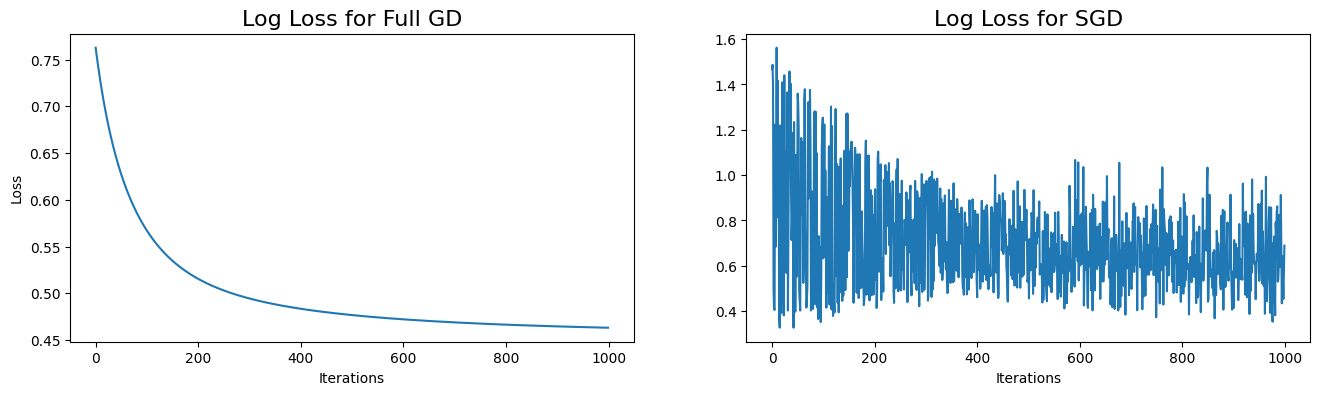

In [76]:
import matplotlib.pyplot as plt

X_train_scaled = scaler.fit_transform(X_train)
logregr_full = MyLogisticRegression(gd_type="full", eta=1e-1, max_iter=1000)
model_full = logregr_full.fit(X_train_scaled, y_train)
logregr_sgd = MyLogisticRegression(gd_type="stochastic", eta=1e-2, max_iter=1000)
model_sgd = logregr_sgd.fit(X_train_scaled, y_train)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axes[0].plot(model_full.loss_history, label="Full GD")
axes[0].set_title("Log Loss for Full GD", fontsize=16)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Iterations")
axes[1].plot(model_sgd.loss_history, label="SGD GD")
axes[1].set_title("Log Loss for SGD", fontsize=16)
axes[1].set_xlabel("Iterations")

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

ROC_AUC score: 0.7981749371909554
PR_AUC score: 0.8608159574978798


Text(0.5, 1.0, 'ROC-AUC curve fo model')

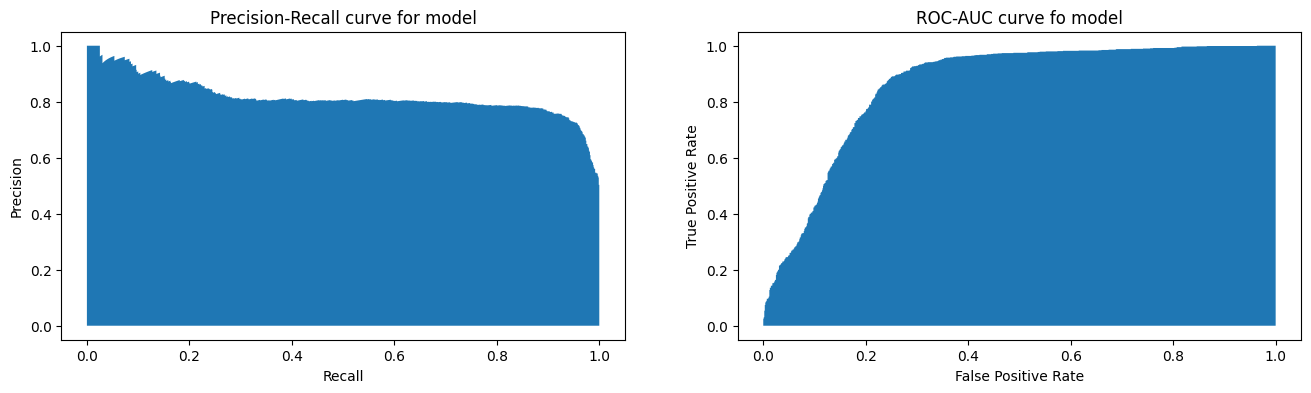

In [77]:
# your code
# precision_recall_curve, roc_auc_score, roc_curve, auc
y_pred = model_full.predict(X_test)
y_proba = model_full.predict_proba(X_test)

# Get the metrics
score_roc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
score_pr = auc(fpr, tpr)


print(f"ROC_AUC score: {score_roc}")
print(f"PR_AUC score: {score_pr}")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
# Drawing Test Precision-Recall curve

axes[0].fill_between(recall, precision)
axes[0].set_ylabel("Precision")
axes[0].set_xlabel("Recall")
axes[0].set_title("Precision-Recall curve for model")
# Drawing ROC curve

axes[1].fill_between(fpr, tpr)
axes[1].set_ylabel("True Positive Rate")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_title("ROC-AUC curve fo model")

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [78]:
# your code
k = 5
kf = KFold(n_splits=k, random_state=None)
model = MyLogisticRegression(gd_type="full", eta=1e-1, max_iter=1000)

scores_roc_auc = []
scores_pr_auc = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Fit the model
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)

    # get metrics
    score_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    score_pr = auc(fpr, tpr)
    score_roc = roc_auc_score(pred_values, y_test)
    # collect the scores
    scores_roc_auc.append(score_roc)
    scores_pr_auc.append(score_pr)

avg_roc_score = sum(scores_roc_auc) / k
avg_pr_score = sum(scores_pr_auc) / k

print(f"Scores of each fold - \n ROC-AUC: {scores_roc_auc} \n PR-AUC: {scores_pr_auc}")
print(f"Avg accuracy : - \n ROC-AUC: {avg_roc_score} \n PR-AUC: {avg_pr_score}")

Scores of each fold - 
 ROC-AUC: [0.798594622054936, 0.7951877552042885, 0.8042256540537508, 0.8013125173254697, 0.7847007495426657] 
 PR-AUC: [0.5013087211738783, 0.4907378518056289, 0.5076401188496268, 0.49052599999999996, 0.5152967670903813]
Avg accuracy : - 
 ROC-AUC: 0.7968042596362221 
 PR-AUC: 0.5011018917839031


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [79]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [80]:
# `load_boston` has been removed from scikit-learn since version 1.2.

# from sklearn.datasets import load_boston
# boston = load_boston()

In [96]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
# data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [89]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [94]:
feature_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
]

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=["MEDV"], index=range(len(target)))

X["target"] = y

In [95]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [85]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [86]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code

SyntaxError: incomplete input (1467579199.py, line 2)

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [ ]:
# your code

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

In [ ]:
# your code